## Data Analysis of Daily PM10 and PM2.5

### Importing Data

The particulate matter data show some differences each other, on one hand the PM2.5 present fewer input variables as well some different type of variables if we compare these data with PM10. This document is focused on the statistical meaning of the data in particular the daily variables that can be retrieved from the original data set. Finally, the regressors are saved to be used in a predictive model.

In [1]:
#Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.io import loadmat

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import max_error, median_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays

from statsmodels.tsa.seasonal import seasonal_decompose

import pylab
import scipy.stats as stats

In [2]:
def read_files_PM():
    #Reading data and naming Columns
    PM25data=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
    PM10data=loadmat('data_Polish.mat')
    PM10data=pd.DataFrame.from_dict(PM10data['x'])
    PM10data.columns = ['PM_10','SO2','NO_2','OZON','WIND_SPEED', 'WIND_DIR', 'TEMP', 'PROM_SLON', 'WILGOT', 'WIND_X', 'WIND_Y']
    return PM25data, PM10data 

### NAN Values in datasets 

There are some NaN numbers in the PM2.5 data, it can be seen in the following two cells. On possible way may be to interpolate the missing values with the known ones and ensure all dataset will have defined values.The interpolation is then carried out, nevertheless, the first 24 data points are still missing, thus they are removed completely.

In [3]:
#Interpolation and removing NAN Values from PM2.5 data, new data index is set. 
PM25data, PM10data =read_files_PM()
PM25_interpolate=PM25data['pm2.5'].fillna(method='ffill')
PM25data_clean=PM25data
PM25data_clean['pm2.5']=PM25_interpolate
PM25data_clean=PM25data_clean[24:]
i_PM10 = pd.date_range('2006-01-01', periods=len(PM10data), freq='H')
PM10data.index=i_PM10
PM25data_clean=PM25data_clean.set_index(['year', 'month','day','hour'])
PM25data=PM25data_clean
PM25data.drop(['No'], axis=1, inplace=True)
PM25data['new_idx']=pd.to_datetime(PM25data.index.to_frame())
PM25data.set_index('new_idx', inplace=True)

### Daily Regressors

The daily regressors are now generated calculating the mean of each variable every 24 hours, the vales from non numeric variables are removed from the newly created dataframe. The boxplots show higher variability in the PM2.5 data, in both data however, several outliers points appear. Then, the datasets are scaled in order to have be processed by the models. 

The box plots show a large amount of outliers appearing in both data, in particular the PM2.5 have outliers more spread outside of the theoretical line in the probability plot with normal distribution model.

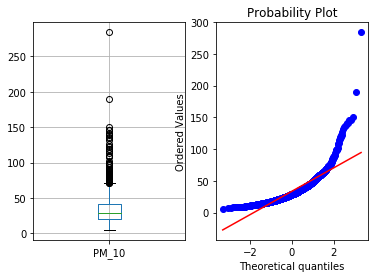

In [4]:
#Boxplots of Daily PM10 and probability Plot
PM10_daily=PM10data.resample('d').mean()
fig, axs = plt.subplots(1,2)
boxplot1 = PM10_daily.boxplot(column=['PM_10'], ax=axs[0])
stats.probplot(PM10_daily['PM_10'], dist="norm", plot=axs[1])
pylab.show()

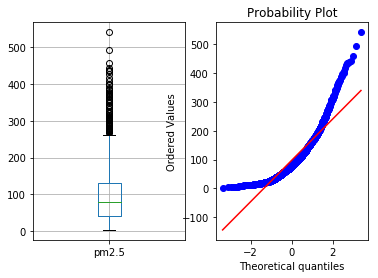

In [5]:
#Boxplots of Daily PM25 and probability Plot
PM25_daily=PM25data.resample('d').mean()
fig, axs = plt.subplots(1,2)
PM25_daily.boxplot(column=['pm2.5'], ax=axs[0])
stats.probplot(PM25_daily['pm2.5'], dist="norm", plot=axs[1])
pylab.show()

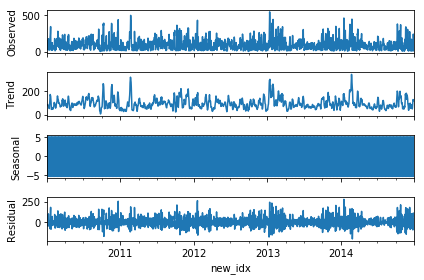

In [6]:
result = seasonal_decompose(PM25_daily['pm2.5'])
fig = result.plot()

### Minimum and Maximum 

In [7]:
#Minimum and maximum->
Max_PM10=PM10data.resample('d').max()
Min_PM10=PM10data.resample('d').min()

Max_PM25=PM25data.resample('d').max()
Min_PM25=PM25data.resample('d').min()

In [8]:
#Rename Columns of new regressors

A=np.array(Min_PM10.columns)
B=[A for A in A + "_Min"]    
Min_PM10.columns=B

A=np.array(Min_PM25.columns)
B=[A for A in A + "_Min"]    
Min_PM25.columns=B

A=np.array(Max_PM10.columns)
B=[A for A in A + "_Max"]    
Max_PM10.columns=B

A=np.array(Max_PM25.columns)
B=[A for A in A + "_Max"]    
Max_PM25.columns=B


In [9]:
#Separating Regressors and target
X_PM10=PM10_daily.loc[:, PM10_daily.columns != 'PM_10']
y_PM10=PM10_daily[['PM_10']]

X_PM25=PM25_daily.loc[:,PM25_daily.columns != 'pm2.5'] #Drop PM2.5
X_PM25=X_PM25.drop(columns='Ir') #Drop IR
y_PM25=PM25_daily[['pm2.5']]

In [10]:
# Including Variables into regressors
Regressors_PM10 = pd.concat([X_PM10, Max_PM10, Min_PM10], axis=1)
Regressors_PM25 = pd.concat([X_PM25, Max_PM25, Min_PM25], axis=1)

In [11]:
#Discarding first day of PM and last day of Meteorological var
y_PM25=y_PM25.drop(y_PM25.head(1).index)
X_PM25=Regressors_PM25.drop(Regressors_PM25.tail(1).index)
y_PM10=y_PM10.drop(y_PM10.head(1).index)
X_PM10=Regressors_PM10.drop(Regressors_PM10.tail(1).index)

In [12]:
y_PM25.to_csv('y_PM25')
X_PM25.to_csv('X_PM25')
y_PM10.to_csv('y_PM10')
X_PM10.to_csv('X_PM10')